#Proyek Pertama - Part 2 : Analisis Sentimen Komentar Penilaian Barang Flash Sale Shopee


*   Nama: Michelle Angelina
*   Email: zmichelleangelina@gmail.com
*   ID Dicoding: mchelle_angelina

## Preparation

#### Import Library

In [28]:
## Library Imports
import requests
import pandas as pd
import re
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, InputLayer, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
import numpy as np

#### Cleansing Data and Labeling

In [2]:
df = pd.read_csv("flash_sale_reviews.csv")
df = df.dropna(subset=["username", "comment", "rating"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11224 entries, 0 to 14097
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  11224 non-null  object
 1   rating    11224 non-null  int64 
 2   comment   11224 non-null  object
 3   time      11224 non-null  object
 4   product   11224 non-null  object
dtypes: int64(1), object(4)
memory usage: 526.1+ KB
None


In [3]:
## Hapus Simbol, Emoji, URL, dan Normalisasi teks menjadi huruf kecil

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)

    text = text.lower()
    return text

df["comment"] = df["comment"].apply(clean_text)

In [4]:
def label_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["rating"].apply(label_sentiment)

## Skema 1: Ekstraksi Fitur TF-IDF with LSTM Model Training | 80/20 Dataset Split

#### 80/20  Split Dataset

In [5]:
X = df["comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 8979
Testing data: 2245


#### Ekstraksi Fitur dengan TF-IDF

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Fitur training: {X_train_tfidf.shape}")
print(f"Fitur testing: {X_test_tfidf.shape}")

Fitur training: (8979, 5000)
Fitur testing: (2245, 5000)


In [7]:
df.to_csv("flash_sale_reviews_preprocessed_tfidf.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_tfidf.csv.")

Data disimpan di flash_sale_reviews_preprocessed_tfidf.csv.


#### LSTM Model

In [8]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenization dan padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Membuat model LSTM
model_1 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: positive, neutral, negative
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_1 = model_1.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_test_pad, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8572 - loss: 0.5115 - val_accuracy: 0.9154 - val_loss: 0.2710
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 196s 967ms/step - accuracy: 0.9261 - loss: 0.2454 - val_accuracy: 0.9189 - val_loss: 0.2700
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 134s 947ms/step - accuracy: 0.9402 - loss: 0.1912 - val_accuracy: 0.9189 - val_loss: 0.2801
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 939ms/step - accuracy: 0.9415 - loss: 0.1694 - val_accuracy: 0.9136 - val_loss: 0.2977
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 936ms/step - accuracy: 0.9492 - loss: 0.1436 - val_accuracy: 0.8993 - val_loss: 0.3690


In [9]:
loss, accuracy = model_1.evaluate(X_test_pad, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.9208 - loss: 0.2624
Testing Accuracy: 91.89%


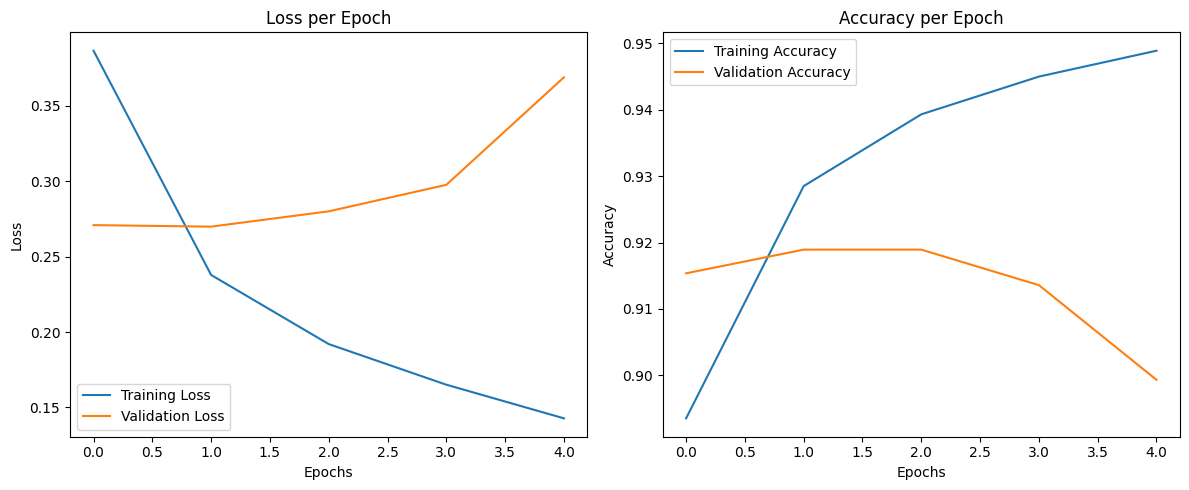

In [10]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Skema 2: Ekstraksi Fitur Word2Vec with LSTM Model Training | 85/15 Dataset Split

#### 85/15 Split Dataset

In [11]:
X = df["comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 9540
Testing data: 1684


#### Ekstraksi Fitur dengan Word2Vec

In [12]:
tokenized_sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2)

def transform_to_w2v(data, w2v_model):
    return np.array([
        np.mean([w2v_model.wv[word] for word in sentence.split() if word in w2v_model.wv] or [np.zeros(100)], axis=0)
        for sentence in data
    ])

X_train_w2v = transform_to_w2v(X_train, w2v_model)
X_test_w2v = transform_to_w2v(X_test, w2v_model)

In [13]:
df.to_csv("flash_sale_reviews_preprocessed_w2v.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_w2v.csv.")

Data disimpan di flash_sale_reviews_preprocessed_w2v.csv.


#### LSTM Model

In [14]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_w2v = X_train_w2v.reshape(X_train_w2v.shape[0], X_train_w2v.shape[1], 1)
X_test_w2v = X_test_w2v.reshape(X_test_w2v.shape[0], X_test_w2v.shape[1], 1)

model_2 = Sequential([
    InputLayer(input_shape=(100, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    X_train_w2v, y_train_encoded,
    validation_data=(X_test_w2v, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 137s 810ms/step - accuracy: 0.8644 - loss: 0.5707 - val_accuracy: 0.8735 - val_loss: 0.5219
Epoch 2/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 748ms/step - accuracy: 0.8910 - loss: 0.3884 - val_accuracy: 0.8777 - val_loss: 0.3740
Epoch 3/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 722ms/step - accuracy: 0.8832 - loss: 0.3753 - val_accuracy: 0.8795 - val_loss: 0.3944
Epoch 4/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 143s 726ms/step - accuracy: 0.8884 - loss: 0.3660 - val_accuracy: 0.8842 - val_loss: 0.3763
Epoch 5/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 112s 745ms/step - accuracy: 0.9008 - loss: 0.3313 - val_accuracy: 0.8818 - val_loss: 0.3640
Epoch 6/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 727ms/step - accuracy: 0.8952 - loss: 0.3359 - val_accuracy: 0.8913 - val_loss: 0.3436
Epoch 7/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 731ms/step - accuracy: 0.8978 - loss: 0.3273 - val_accuracy: 0.8830 - val_loss: 0.3530
Epoch 8/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 728ms/step - accuracy: 0.8969 -

In [15]:
loss, accuracy = model_2.evaluate(X_test_w2v, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8952 - loss: 0.3546
Testing Accuracy: 89.13%


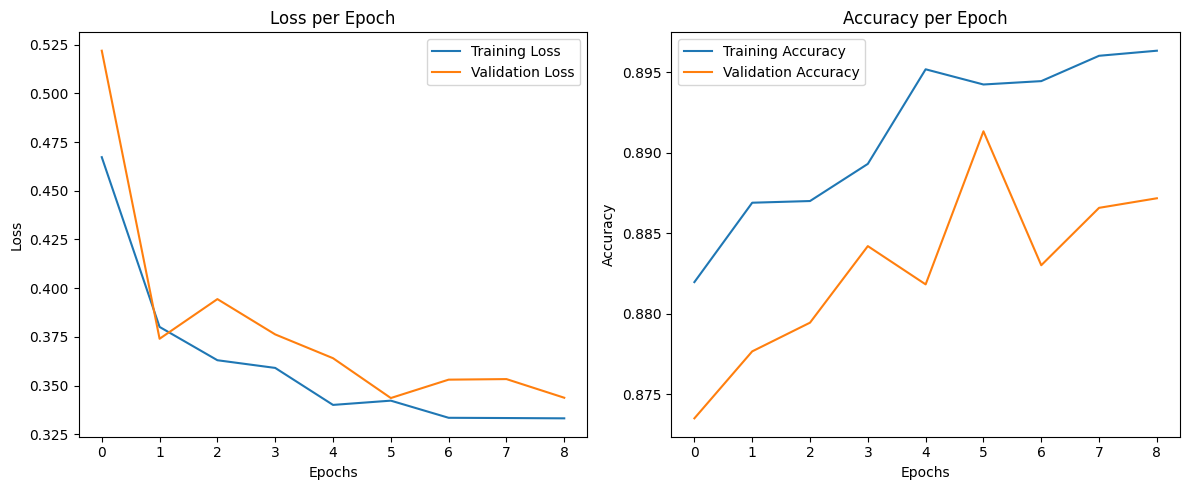

In [16]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Skema 3: Ekstraksi Fitur Count Vectorizer with GRU Model Training | 80/20 Dataset Split

#### 80/20 Split Dataset

In [17]:
X = df["comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 8979
Testing data: 2245


#### Ekstraksi Fitur dengan Count Vectorizer

In [18]:
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_cv = count_vectorizer.fit_transform(X_train).toarray()
X_test_cv = count_vectorizer.transform(X_test).toarray()

In [19]:
df.to_csv("flash_sale_reviews_preprocessed_cv.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_cv.csv.")

Data disimpan di flash_sale_reviews_preprocessed_cv.csv.


#### CNN Model

In [29]:
X_train_cv = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
X_test_cv = X_test_cv.reshape(X_test_cv.shape[0], X_test_cv.shape[1], 1)

model = Sequential([
    InputLayer(input_shape=(X_train_cv.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_cv, y_train_encoded,
    validation_data=(X_test_cv, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8771 - loss: 0.4019 - val_accuracy: 0.9051 - val_loss: 0.2896
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9270 - loss: 0.2196 - val_accuracy: 0.9167 - val_loss: 0.2769
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9359 - loss: 0.1838 - val_accuracy: 0.9185 - val_loss: 0.2739
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9456 - loss: 0.1610 - val_accuracy: 0.9167 - val_loss: 0.2933
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.9579 - loss: 0.1211 - val_accuracy: 0.9114 - val_loss: 0.3297
Epoch 6/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9653 - loss: 0.0978 - val_accuracy: 0.9056 - val_loss: 0.3751


In [30]:
loss, accuracy = model.evaluate(X_test_cv, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9204 - loss: 0.2608
Testing Accuracy: 91.85%


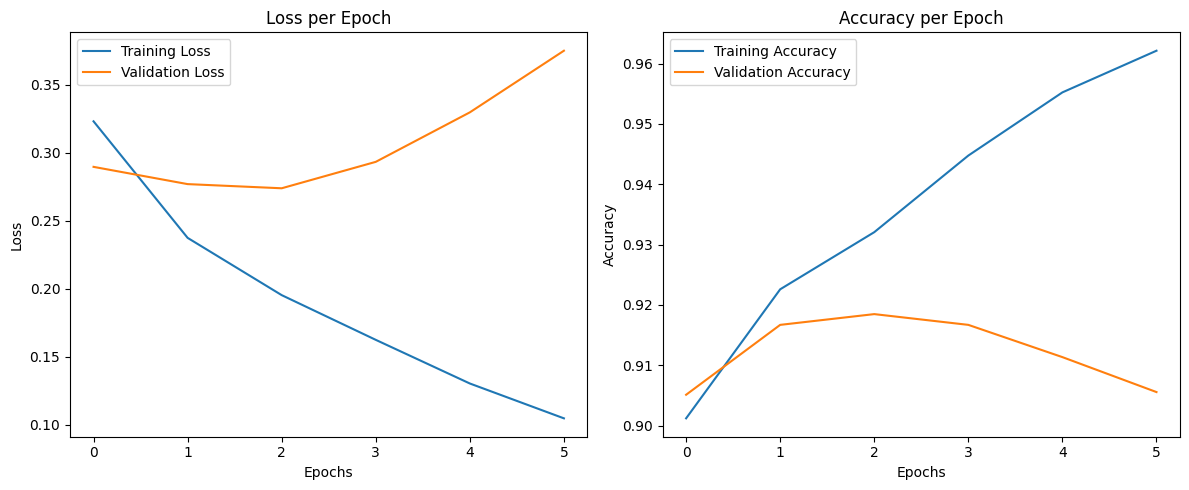

In [31]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Inference

#### Menggunakan Skema 3 dengan Hasil Training dan Testing Tertinggi

In [34]:
def predict_sentiment(text, model, tokenizer, max_length, label_encoder):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model_1.predict(padded_sequence)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

sample_text = "gila jelek kali ini parfum. gak mau beli lg disini dh"
predicted_sentiment = predict_sentiment(sample_text, model_1, tokenizer, max_length, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted Sentiment: negative


In [35]:
sample_text = "Produk ini bagus banget, okelahh bakal beli lagi di sini"
predicted_sentiment = predict_sentiment(sample_text, model_1, tokenizer, max_length, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Sentiment: positive


In [39]:
sample_text = "tidak terlalu sepadan dengan harga"
predicted_sentiment = predict_sentiment(sample_text, model_1, tokenizer, max_length, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Sentiment: negative
